# 1,2,3 Classification
In this tutorial, I'll go throgh some implementations details you maybe use in your final project:
1. how to load the dataset
2. how to use pre-processing
3. how to train the model
4. how to save and load your model weights
5. how to evaluate the model
6. how to make predictions on testing images
7. [Extra.] how to use 1-D convolution
8. [Extra.] how to create spectrogram

# Install Library

In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib
!pip install librosa
!pip install scipy

You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/timmy/Downloads/Bearing Vibration/venv/bin/python -m pip install --upgrade pip' command.


# Import Library

In [2]:
import torch # for importing Pytorch
import torch.optim as optim # for optimizer setup
import torch.nn as nn # for buildup Pytorch's model architecture
import torch.nn.functional as F # for applying useful functions like activation
from torch.utils.data import Dataset, DataLoader # for data I/O
from torchvision.transforms import ToTensor # for input preprocessing
import numpy as np # for N-dim array operations
import os # for fetching folder structure
from PIL import Image # for image I/O
from glob import glob # for fetching folder structure
import matplotlib.pyplot as plt # for visualizing your result
from time import time # for elapsed time measurement
print("pytorch version:",torch.__version__)

pytorch version: 1.7.1


In [3]:
![ -e weight.pth ] && rm weight.pth # remove a previously trained checkpoint if it already exist

# Dataset structure

In [4]:
# set the dataset root folder
dataset = "." # set current folder
print("The tutorial dataset folder structure is arranged as below:")
print(dataset)
for name in os.listdir(dataset):
    if name in [".DS_Store",".ipynb_checkpoints"]: continue
    print("├──",name)
    path = os.path.join(dataset, name)
    if os.path.isdir(path):
        for item in os.listdir(path):
            print("    ├──",item)

The tutorial dataset folder structure is arranged as below:
.
├── trainlabel.npy
├── test
    ├── 1384.jpg
    ├── 1395.jpg
    ├── 1118.jpg
    ├── 306.jpg
    ├── 1282.jpg
    ├── 357.jpg
├── validationdata.npy
├── validationlabel.npy
├── Tutorial.ipynb
├── traindata.npy


# Data loading and preprocessing
In order to train the model with data, the first step is to read the data from matrix files, database etc. The below is just an example.

In [5]:
traindata, trainlabel = np.load(os.path.join(dataset,"traindata.npy")), np.load(os.path.join(dataset,"trainlabel.npy"))
print("traindata",traindata.shape,traindata.dtype)
print("trainlabel",trainlabel.shape,trainlabel.dtype)
valdata, vallabel = np.load(os.path.join(dataset,'validationdata.npy')), np.load(os.path.join(dataset,"validationlabel.npy"))
print("valdata",valdata.shape,valdata.dtype)
print("vallabel",vallabel.shape,vallabel.dtype)

traindata (1500, 32, 32) uint8
trainlabel (1500,) int8
valdata (30, 32, 32) uint8
vallabel (30,) int8


# Before the start of processing, we assume the class label to class name mapping as below:

<table>
    <tr><td>class label</td><td>class name</td>
    <tr><td>0</td><td>one</td>
    <tr><td>1</td><td>two</td>
    <tr><td>2</td><td>three</td>
</table>

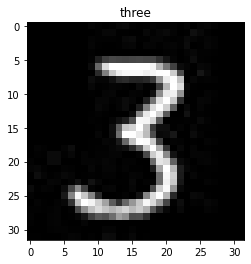

In [6]:
label_to_name = {
    0 : "one",
    1 : "two",
    2 : "three",
}
n_th = 3
img = traindata[n_th]
class_name = label_to_name[trainlabel[n_th]]
plt.imshow(img,cmap='gray')
plt.title(class_name)
plt.show()

# Customize your dataset

In [7]:
# customize your dataset
class MyDataset(Dataset):
    # To learn more, please see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, data, label, label_to_name, transform):
        self.sample_list = data # set input
        self.label_list = torch.from_numpy(label.astype(np.int64)) # set output (ground truth)
        self.transform = transform # set the preprocessing pipeline

    def __len__(self):
        return len(self.sample_list)# return the size of the dataset.

    def __getitem__(self, idx):
        sample = self.sample_list[idx] # fetch a single grayscale image
        sample = self.transform(sample)# preprocess
        label = self.label_list[idx] # fetch the corresponding label
        return sample, label# get the i-th sample and its corresponding label
# customize your preprocessing
mytransforms = ToTensor() # convert a matrix in range [0,255] to a FloatTensor in range [0.0,1.0]
# initialize training set and its corresponding loader
trainset = MyDataset(traindata,trainlabel,label_to_name, transform=mytransforms)
trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
# initialize validation set and its corresponding loader
valset = MyDataset(valdata,vallabel,label_to_name,transform=mytransforms)
valloader = DataLoader(valset,batch_size=64,shuffle=True)

# Build neural network: LeNet
About model details, please see the homework slide.

In [8]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [9]:
net = Net(num_classes=len(label_to_name)) # initialize your network
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05) # setup your optimizer
criterion = nn.CrossEntropyLoss() # setup your criterion

use cpu now!


# Train the model with the data

In [10]:
start = time()
net.train()
num_epoch = 15
for epoch in range(num_epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        #print(data.shape,data.dtype,target.shape,target.dtype)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('epoch %d, iter %d, training loss: %.3f' %(epoch+1, batch_idx+1, loss.item()))
print("Elapsed Time:",time()-start,"seconds")

epoch 1, iter 1, training loss: 1.099
epoch 1, iter 11, training loss: 1.094
epoch 1, iter 21, training loss: 1.092
epoch 2, iter 1, training loss: 1.090
epoch 2, iter 11, training loss: 1.083
epoch 2, iter 21, training loss: 1.066
epoch 3, iter 1, training loss: 1.064
epoch 3, iter 11, training loss: 1.036
epoch 3, iter 21, training loss: 0.962
epoch 4, iter 1, training loss: 0.908
epoch 4, iter 11, training loss: 0.675
epoch 4, iter 21, training loss: 0.514
epoch 5, iter 1, training loss: 0.345
epoch 5, iter 11, training loss: 0.389
epoch 5, iter 21, training loss: 0.393
epoch 6, iter 1, training loss: 0.164
epoch 6, iter 11, training loss: 0.249
epoch 6, iter 21, training loss: 0.281
epoch 7, iter 1, training loss: 0.134
epoch 7, iter 11, training loss: 0.130
epoch 7, iter 21, training loss: 0.163
epoch 8, iter 1, training loss: 0.166
epoch 8, iter 11, training loss: 0.088
epoch 8, iter 21, training loss: 0.252
epoch 9, iter 1, training loss: 0.075
epoch 9, iter 11, training loss: 0

# Save model

In [11]:
def save_model(model,filename):
    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()
    torch.save(state, filename)
save_model(net,"weight.pth")

# Load pretrained weights

In [12]:
def load_model(model,filename):
    model.load_state_dict(torch.load(filename))
    return model
net = Net(num_classes=len(label_to_name)) # initialize your network
net = load_model(net,"weight.pth")
# Whether to use GPU or not?
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'
print("use",device,"now!")
net.to(device)

use cpu now!


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

# Evaluate on validation data

In [13]:
net.eval()
correct = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valloader):
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    acc = correct.item() / len(valloader.dataset)
print("Validation Classification Accuracy: %f"%(acc))

Validation Classification Accuracy: 0.966667


# Make predictions on testing images

predict ./test/1384.jpg => one
predict ./test/1395.jpg => one
predict ./test/1118.jpg => three
predict ./test/306.jpg => two
predict ./test/1282.jpg => three
predict ./test/357.jpg => two


<ipython-input-14-0a1cb3505181>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, columns, x+1)


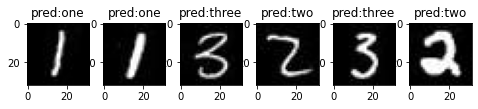

In [14]:
# fetch filepaths of the testing images
testpath = os.path.join(dataset,"test")
# make predictions
result = {}
net.eval()
with torch.no_grad():
    for imgpath in glob(os.path.join(testpath,"*.jpg")):
        img = Image.open(imgpath).convert("L")# load grayscale image
        sample = mytransforms(img) # preprocess
        #print(sample.shape)#torch.Size([1, 32, 32])
        sample = torch.stack([sample])
        #print(sample.shape)#torch.Size([1, 1, 32, 32])
        sample = sample.to(device)
        output = net(sample)
        pred_idx = output.data.max(1, keepdim=True)[1]
        pred_class = label_to_name[pred_idx.cpu().numpy()[0][0]]
        result[imgpath] = pred_class
        print("predict",imgpath,"=>",pred_class)
# Visualize your results
size = 8
fig = plt.figure(figsize=(size, size))
columns = len(result)
rows = np.ceil(len(result))
for x, filepath in enumerate(result):
    img = plt.imread(filepath)
    ax = fig.add_subplot(rows, columns, x+1)
    ax.set_title("pred:%s"%(result[filepath]))
    plt.imshow(img,cmap='gray')
plt.show()

# [Extra.] 1-D convolution
1-D convolution is helpful for analying 1D Convolutional time series sensor data. To introduce how to use 1-D convolution in Pytorch, we will create code snippers to handle time series data like below: 
<img src="https://cezannec.github.io/assets/cnn_text/conv_maxpooling_steps.gif" width="600" align="center">
To learn more, please see <a href="https://cezannec.github.io/CNN_Text_Classification/">here</a>

In [15]:
batch_size = 1
embedding_dimension = input_channel = 3
sequence_length = 6
# create input
input_sample = torch.randn(batch_size, embedding_dimension, sequence_length)
print("the shape of input data:",input_sample.shape)
# define 1-d convolution
operation = nn.Conv1d(in_channels=embedding_dimension, out_channels=1, kernel_size=3, stride=1, padding=1)
# check output
output = operation(input_sample)
print("the shape of feature vector:",output.shape)

the shape of input data: torch.Size([1, 3, 6])
the shape of feature vector: torch.Size([1, 1, 6])


# [Extra.] Spectrogram
Spectrogram is a two-dimensional map (like a 2-D image) representing the signal strength over time. To generate the spectrograms from input signals, you can achieve the goal using following libraries:

[1] <a href="https://pytorch.org/audio/stable/transforms.html#spectrogram">torchaudio.transforms.Spectrogram</a>

[2] <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html">scipy.signal.spectrogram</a>

[3] <a href="https://librosa.org/doc/0.8.0/generated/librosa.stft.html">librosa.stft</a>

In this section, we create small code snippets to convert audio clip to spectrograms as below.

In [16]:
import librosa
sampling_rate = 16000
print("load audio data")
signaldata, sampling_rate = librosa.load(librosa.util.example_audio_file(),sr=sampling_rate)
print("signal length:",signaldata.shape,"sampling_rate:",sampling_rate)

load audio data
signal length: (983342,) sampling_rate: 16000


In [17]:
print("Scipy Version")
from scipy import signal
# create magnitude spectrogram
f, t, Sxx = signal.spectrogram(signaldata,fs=sampling_rate,window="hann",nperseg=256,noverlap=32,scaling="spectrum",mode="magnitude")
print("The shape of magnitude spectrogram:",Sxx.shape)
# create phase spectrogram
f, t, Sxx = signal.spectrogram(signaldata,fs=sampling_rate,window="hann",nperseg=256,noverlap=32,scaling="spectrum",mode="phase")
print("The shape of phase spectrogram:",Sxx.shape)

Scipy Version
The shape of magnitude spectrogram: (129, 4389)
The shape of phase spectrogram: (129, 4389)


In [18]:
print("Librosa Version")
# Calculate the spectrogram as the square of the complex magnitude of the STFT
Sxx = np.abs(librosa.stft(signaldata, n_fft=256, hop_length=256-32, win_length=256, window='hann'))**2
print("The shape of magnitude spectrogram:",Sxx.shape)
# To learn more, please see https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/audio_processing/spectrogram.html

Librosa Version
The shape of magnitude spectrogram: (129, 4390)


# If you want to trian the model with spectrogram data, please customize your dataset and dataloader as previously mentioned. Hint: see "<i>Data loading and preprocessing</i>"

~~~~
Note. To avoid repeated spectrogram generation procedure, you can save the spectrogram (i.e. Sxx) as numpy array first and then reload it. E.g. 
>>> np.save("spectrogram.npy",Sxx)
>>> Sxx = np.load("spectrogram.npy")
~~~~